In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
import re

from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# News headline dataset

https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection <br>

## Import data

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lisanvo13","key":"c12fa77a8c7ef1c3f5a9a56c751ac750"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
#!/bin/bash
!kaggle datasets download "rmisra/news-headlines-dataset-for-sarcasm-detection"

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
License(s): Attribution 4.0 International (CC BY 4.0)
news-headlines-dataset-for-sarcasm-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip data
!mkdir "/content/news-headlines-dataset"
!unzip "/content/news-headlines-dataset-for-sarcasm-detection.zip" -d "/content/news-headlines-dataset"

mkdir: cannot create directory ‘/content/news-headlines-dataset’: File exists
Archive:  /content/news-headlines-dataset-for-sarcasm-detection.zip
replace /content/news-headlines-dataset/Sarcasm_Headlines_Dataset.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# Read JSON file into DataFrame
df = pd.read_json("/content/news-headlines-dataset/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## EDA

In [3]:
df.dtypes

,0
is_sarcastic,int64
headline,object
article_link,object


In [4]:
# Check for NaN values
df.isnull().sum()

,0
is_sarcastic,0
headline,0
article_link,0


In [5]:
# Check for class imbalance
df["is_sarcastic"].value_counts()

,count
is_sarcastic,
0,14985
1,13634


In [6]:
# Check character count of a headline
length = len(df['headline'][0])
print(f'Length of a sample headline: {length}')

Length of a sample headline: 61


### Word count

In [7]:
# Check word count
word_count = df['headline'][0].split()
# Check word count of each headline and store in a new column
df['word_count'] = df['headline'].map(lambda rev: len(rev.split()))

print(f'Word count in a sample headline: {len(word_count)}')

Word count in a sample headline: 8


### Mean word length

In [8]:
# Calculate mean word length
df['mean_word_length'] = df['headline'].map(lambda rev: np.mean([len(word) for word in rev.split()]))

In [9]:
df.head()

,is_sarcastic,headline,article_link,word_count,mean_word_length
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8,6.750000
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13,5.153846
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7,6.142857
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8,5.625000
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9,5.888889


### Remove stop words

In [10]:
# Remove stop words from each headline and store result in new column
stop_words = set(stopwords.words('english'))
df['headline_without_stopwords'] = df['headline'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [11]:
df.head()

,is_sarcastic,headline,article_link,word_count,mean_word_length,headline_without_stopwords
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8,6.750000,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13,5.153846,dem rep. totally nails congress falling short ...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7,6.142857,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8,5.625000,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9,5.888889,mother comes pretty close using word 'streamin...


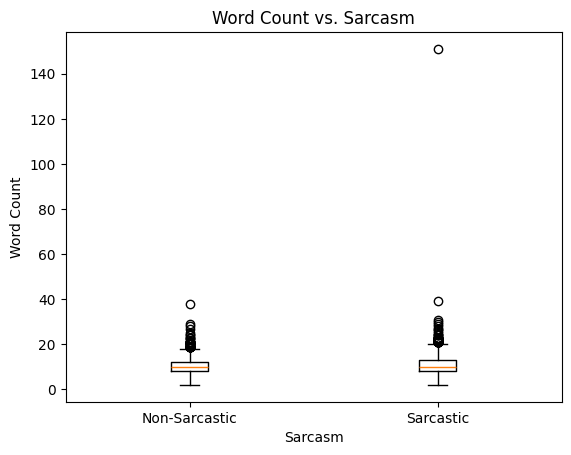

In [12]:
# @title Word Count vs. Sarcasm

import matplotlib.pyplot as plt

# Create box plot
plt.boxplot([df[df['is_sarcastic'] == 0]['word_count'],
             df[df['is_sarcastic'] == 1]['word_count']],
            labels=['Non-Sarcastic', 'Sarcastic'])

# Add labels and title
plt.xlabel('Sarcasm')
plt.ylabel('Word Count')
_ = plt.title('Word Count vs. Sarcasm')

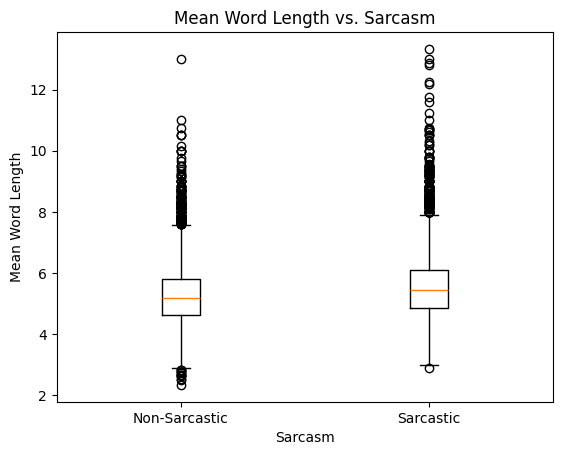

In [13]:
# @title Mean Word Length vs. Sarcasm

import matplotlib.pyplot as plt

# Create box plot
plt.boxplot([df[df['is_sarcastic'] == 0]['mean_word_length'],
             df[df['is_sarcastic'] == 1]['mean_word_length']],
            labels=['Non-Sarcastic', 'Sarcastic'])

# Add labels and title
plt.xlabel('Sarcasm')
plt.ylabel('Mean Word Length')
_ = plt.title('Mean Word Length vs. Sarcasm')

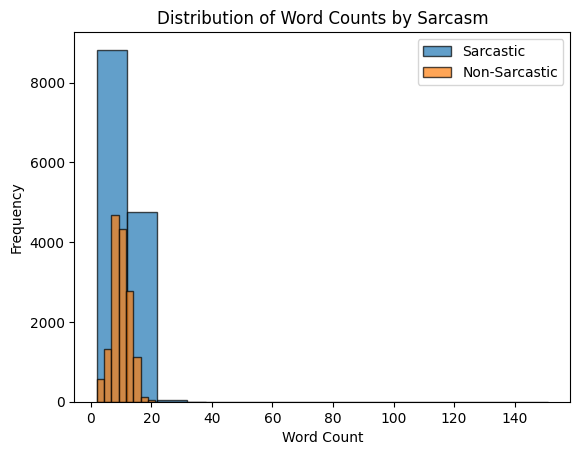

In [14]:
# @title Distribution of Word Counts by Sarcasm

import matplotlib.pyplot as plt

# Filter data for sarcastic and non-sarcastic headlines
sarcastic_headlines = df[df['is_sarcastic'] == 1]['word_count']
non_sarcastic_headlines = df[df['is_sarcastic'] == 0]['word_count']

# Create histograms
plt.hist(sarcastic_headlines, bins=15, alpha=0.7, label='Sarcastic', edgecolor='black')
plt.hist(non_sarcastic_headlines, bins=15, alpha=0.7, label='Non-Sarcastic', edgecolor='black')

# Add labels and title
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts by Sarcasm')

# Add legend
_ = plt.legend()


Text(0, 0.5, 'Word Count')

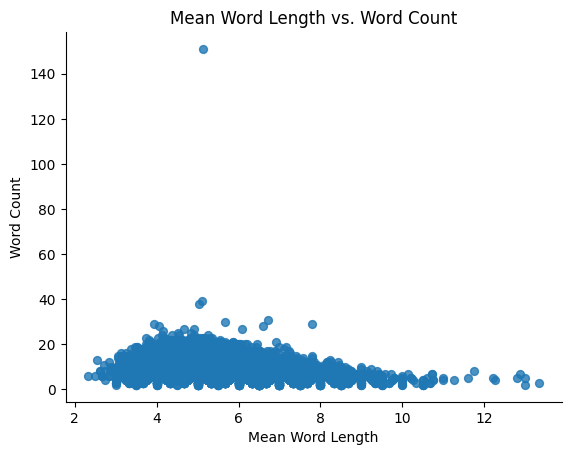

In [15]:
# @title Mean Word Length vs. Word Count

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='mean_word_length', y='word_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Mean Word Length vs. Word Count')
plt.xlabel('Mean Word Length')
plt.ylabel('Word Count')

## Mean sentence length

In [16]:
# Calculate mean sentence length
np.mean(df['headline'].map(lambda rev: np.mean([len(sent) for sent in sent_tokenize(rev)])))

61.56791117788882

In [17]:
df.head()

,is_sarcastic,headline,article_link,word_count,mean_word_length,headline_without_stopwords
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8,6.750000,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13,5.153846,dem rep. totally nails congress falling short ...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7,6.142857,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8,5.625000,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9,5.888889,mother comes pretty close using word 'streamin...


## Most Frequently occuring N_grams (ALL)

In [18]:
# Most Frequently occuring N_grams
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['headline'])

In [19]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

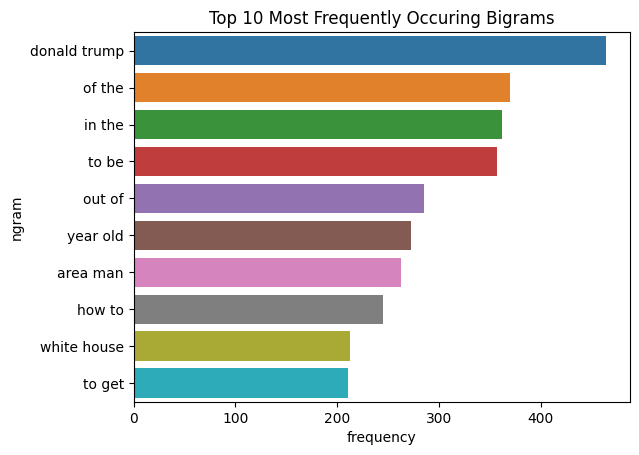

In [20]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [21]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

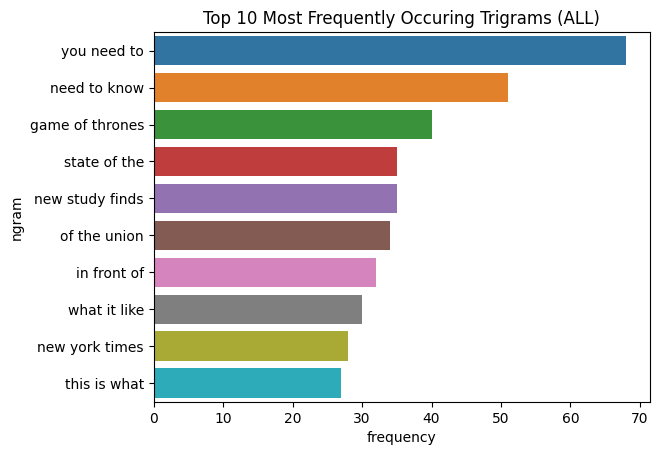

In [22]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams (ALL)')
plt.show()

### Get sarcastic dataframe and non-sarcastic dataframe

In [23]:
# Get all rows where is_sarcastic is 1
df_sarcastic = df[df['is_sarcastic'] == 1]

# Get all rows where is_sarcastic is 0
df_not_sarcastic = df[df['is_sarcastic'] == 0]

In [24]:
df_sarcastic.head(10)

,is_sarcastic,headline,article_link,word_count,mean_word_length,headline_without_stopwords
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8,6.750000,thirtysomething scientists unveil doomsday clo...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8,5.625000,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9,5.888889,mother comes pretty close using word 'streamin...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...,13,5.846154,richard branson's global-warming donation near...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...,12,5.166667,shadow government getting large meet marriott ...
14,1,ford develops new suv that runs purely on gaso...,https://www.theonion.com/ford-develops-new-suv...,9,4.666667,ford develops new suv runs purely gasoline
16,1,area boy enters jumping-and-touching-tops-of-d...,https://www.theonion.com/area-boy-enters-jumpi...,5,11.000000,area boy enters jumping-and-touching-tops-of-d...
17,1,area man does most of his traveling by gurney,https://local.theonion.com/area-man-does-most-...,9,4.111111,area man traveling gurney
21,1,guard in video game under strict orders to rep...,https://www.theonion.com/guard-in-video-game-u...,14,4.928571,guard video game strict orders repeatedly pace...
25,1,secret service agent not so secret about being...,https://www.theonion.com/secret-service-agent-...,12,4.666667,secret service agent secret david alan grier fan


In [25]:
df_not_sarcastic.head()

,is_sarcastic,headline,article_link,word_count,mean_word_length,headline_without_stopwords
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13,5.153846,dem rep. totally nails congress falling short ...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7,6.142857,eat veggies: 9 deliciously different recipes
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...,3,6.000000,white inheritance
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...,9,3.777778,5 ways file taxes less stress
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...,6,4.833333,lots parents know scenario


## Most Frequently occuring N_grams (SARCASTIC)

In [26]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_sarcastic['headline'])

In [27]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

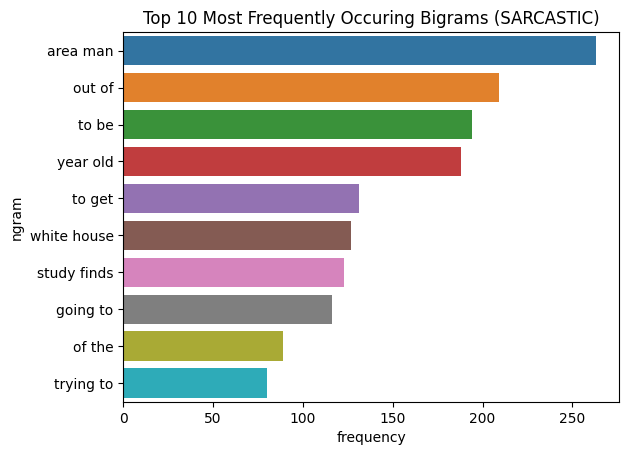

In [28]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams (SARCASTIC)')
plt.show()

In [29]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df_sarcastic['headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

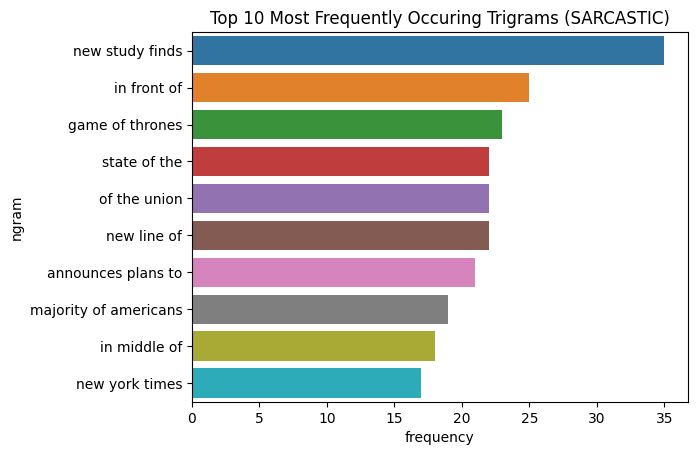

In [30]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams (SARCASTIC)')
plt.show()

## Most Frequently occuring N_grams (NOT SARCASTIC)

In [31]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_not_sarcastic['headline'])

In [32]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

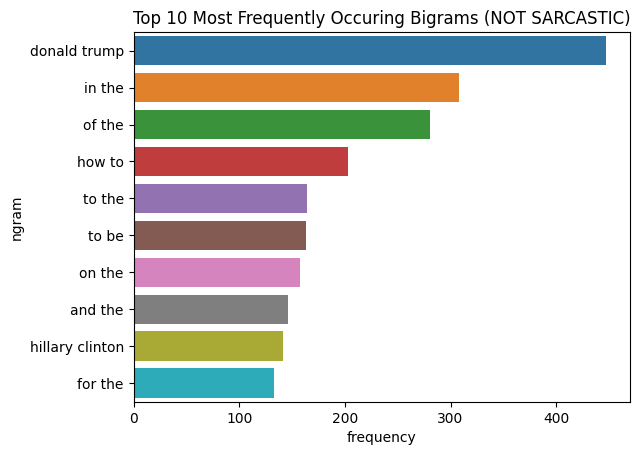

In [33]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams (NOT SARCASTIC)')
plt.show()

In [34]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df_not_sarcastic['headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

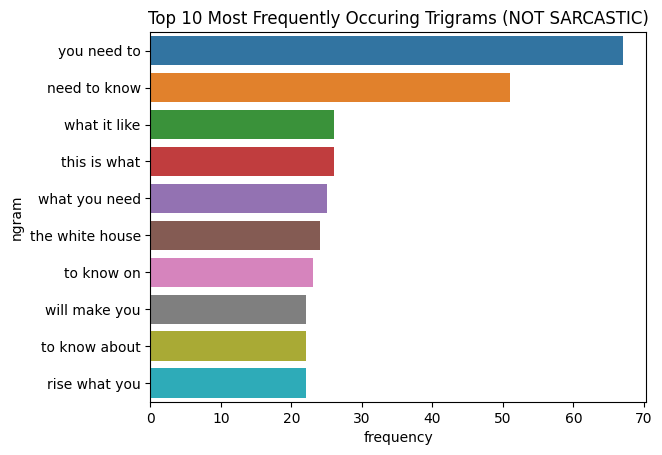

In [35]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams (NOT SARCASTIC)')
plt.show()